In [2]:
from __future__ import print_function, division
import os
from PIL import Image
import pandas as pd


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

In [3]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

vgg16 = models.vgg16_bn()
for param in vgg16.features.parameters():
    param.require_grad = False
class_names = ['other', 'cloud','smoke']

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

vgg16.load_state_dict(torch.load('/home/jszumny/Documents/copy of smoke data/newnew/attempts/3features/fullmodelbest.pt',map_location=torch.device('cpu')))

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
num_features = resnet18.fc.in_features     #extract fc layers features
resnet18.fc = nn.Linear(num_features, 2) #(num_of_class == 2)

resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
num_features = resnet34.fc.in_features     #extract fc layers features
resnet34.fc = nn.Linear(num_features, 2) #(num_of_class == 2)

resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
num_features = resnet50.fc.in_features     #extract fc layers features
resnet50.fc = nn.Linear(num_features, 2) #(num_of_class == 2)


Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jszumny/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jszumny/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jszumny/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the

In [4]:
dir = "/home/jszumny/Arm Data/"

data = []
for file in os.listdir(dir):
    
    for image in os.listdir(dir +file):

        fullimage = Image.open(dir + "/" +  file + "/" +image)
        fullimage = fullimage.resize((1344, 1120))

        for i in range(6):
            for k in range(5):
                
                tile = fullimage.crop((i*224, k*224, (i+1)*224, (k+1)*224))
                
                vgg16.load_state_dict(torch.load('/home/jszumny/Documents/copy of smoke data/newnew/attempts/2features/2featuresVGG16model.pt',map_location=torch.device('cpu')))

                img_t = transform(tile)
                batch_t = torch.unsqueeze(img_t, 0)

                vgg16.eval()
                out = vgg16(batch_t)
            
                _, index = torch.max(out, 1)
            
                percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
                
                d = {"filepath": dir+file+image, "tilenum": str(i) + str(k),"class": class_names[index[0]], "percentage": percentage[index[0]].item()}
                data.append(d)

KeyboardInterrupt: 

In [7]:
df = pd.DataFrame(data)

df[df['class']=='smoke']


,filepath,tilenum,class,percentage


In [8]:
len(df[df["class"] == 'smoke'])/len(df)

0.14156735283495847

In [ ]:
df[df['class']=='smoke']


,filepath,tilenum,class,percentage
0,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,00,smoke,70.337746
5,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,10,smoke,89.789162
6,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,11,smoke,98.951363
10,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,20,smoke,65.970024
11,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,21,smoke,77.337868
...,...,...,...,...
1211,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,21,smoke,60.195953
1215,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,30,smoke,54.713535
1220,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,40,smoke,66.217506
1221,/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20...,41,smoke,80.955437


3 FEATURES
VGG16 - 20% FPR                 
Resnet18 - 3% FPR                   
Resnet34 - 14% FPR                  
Resnet50 - 0% FPR   NO TRUE POSITIVES   

UCSD - 6% FPR

Using cache found in /home/jszumny/.cache/torch/hub/pytorch_vision_v0.10.0


2
smoke  at confidence score:0.55
2
smoke  at confidence score:0.69
2
smoke  at confidence score:0.89
2
smoke  at confidence score:0.97
1
other  at confidence score:0.98
1
other  at confidence score:0.96
1
other  at confidence score:0.93
1
other  at confidence score:0.76
1
other  at confidence score:0.83
1
other  at confidence score:0.95
2
smoke  at confidence score:0.84
2
smoke  at confidence score:0.64
2
smoke  at confidence score:0.97
2
smoke  at confidence score:0.64
1
other  at confidence score:0.93
1
other  at confidence score:0.75
1
other  at confidence score:0.95
1
other  at confidence score:0.93
1
other  at confidence score:0.83
1
other  at confidence score:0.73
2
smoke  at confidence score:0.93
2
smoke  at confidence score:0.91
2
smoke  at confidence score:0.94
2
smoke  at confidence score:0.64
1
other  at confidence score:0.89
1
other  at confidence score:0.95
1
other  at confidence score:0.80
1
other  at confidence score:0.84
1
other  at confidence score:0.79
1
other  at co

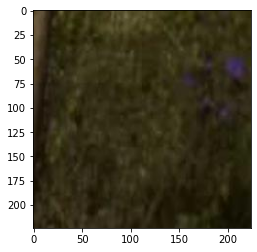

In [4]:
dir = "/home/jszumny/Downloads/"


from PIL import Image
import io

fullimage = Image.open("/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20221001.001123.jpg/enatwrcamtarmacC1.a1.20221001.153223.jpg")
fullimage = fullimage.resize((2688, 2240))


def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)
vgg16 = models.vgg16_bn()

resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
num_features = resnet50.fc.in_features     #extract fc layers features
resnet50.fc = nn.Linear(num_features, 3) #(num_of_class == 2)

for param in vgg16.features.parameters():
    param.require_grad = False
class_names = ["clouds","other", "smoke"]

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    output = vgg16.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    print(classes.item())
    return conf.item(), class_names[classes.item()]


data = []
dir = "/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20221001.001123.jpg/"
imagetime = 0
for image in os.listdir(dir):
    if (int(image[30:36]) >= 144400) & (int(image[30:36]) <= 160000):
        imagetime = image[30:36]
        fullimage = Image.open(dir + image)
        fullimage = fullimage.resize((2688, 2240))
        fullimage.show()

        for i in range(12):
            for k in range(10):
                vgg16.load_state_dict(torch.load('/home/jszumny/Documents/copy of smoke data/newnew/attempts/3features/fullmodelbest.pt',map_location=torch.device('cpu')))

                vgg16.eval()

                tile = fullimage.crop((i*224, k*224, (i+1)*224, (k+1)*224))
                tile.save('/home/jszumny/Documents/test/' + str(i) + str(k) + '.jpg')
                

                image_path= "/home/jszumny/Documents/test/" + str(i) + str(k) + '.jpg'
                image = plt.imread(image_path)
                plt.imshow(image)
                
                with open(image_path, 'rb') as f:
                    image_bytes = f.read()
                    
                    conf,y_pre=get_prediction(image_bytes=image_bytes)
                    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))
            
                d = {"imagetime": imagetime,"tilenum": str(i) + str(k),"class": y_pre, "percentage": '{0:.2f}'.format(conf)}
                data.append(d)

In [5]:
df = pd.DataFrame(data)
df


,imagetime,tilenum,class,percentage
0,153023,00,smoke,0.55
1,153023,01,smoke,0.69
2,153023,02,smoke,0.89
3,153023,03,smoke,0.97
4,153023,04,other,0.98
...,...,...,...,...
9115,150023,115,other,0.92
9116,150023,116,other,0.98
9117,150023,117,other,0.68
9118,150023,118,other,0.97


In [19]:
new = df[df['imagetime']=='150023']
new

,imagetime,tilenum,class,percentage
9000,150023,00,smoke,0.88
9001,150023,01,smoke,0.76
9002,150023,02,smoke,0.55
9003,150023,03,smoke,0.64
9004,150023,04,other,0.98
...,...,...,...,...
9115,150023,115,other,0.92
9116,150023,116,other,0.98
9117,150023,117,other,0.68
9118,150023,118,other,0.97


In [24]:
smoke = df[df["tilenum"] == '34']

In [25]:
smoke[smoke["class"] == 'smoke']

,imagetime,tilenum,class,percentage
154,151123,34,smoke,0.72
394,145023,34,smoke,0.77
994,144623,34,smoke,0.76
1354,145123,34,smoke,0.51
2674,144823,34,smoke,0.62
3154,154723,34,smoke,0.51
3394,144423,34,smoke,0.77
4114,144923,34,smoke,0.52
4474,144523,34,smoke,0.52
5314,153423,34,smoke,0.61


In [26]:
df.to_csv("ArmSmokeDetection.csv")

In [28]:
tile00  = df[df["tilenum"] == '00']
tile00

,imagetime,tilenum,class,percentage
0,153023,00,smoke,0.55
120,151123,00,clouds,0.50
240,155323,00,smoke,0.83
360,145023,00,smoke,0.95
480,150723,00,smoke,0.90
...,...,...,...,...
8520,153723,00,smoke,0.80
8640,155823,00,smoke,0.58
8760,154223,00,smoke,0.77
8880,152123,00,smoke,0.71


In [30]:
tile00[tile00['class']=='smoke']

,imagetime,tilenum,class,percentage
0,153023,00,smoke,0.55
240,155323,00,smoke,0.83
360,145023,00,smoke,0.95
480,150723,00,smoke,0.90
600,152623,00,smoke,0.83
...,...,...,...,...
8520,153723,00,smoke,0.80
8640,155823,00,smoke,0.58
8760,154223,00,smoke,0.77
8880,152123,00,smoke,0.71


In [33]:
df[df['class']=='smoke']

,imagetime,tilenum,class,percentage
0,153023,00,smoke,0.55
1,153023,01,smoke,0.69
2,153023,02,smoke,0.89
3,153023,03,smoke,0.97
10,153023,10,smoke,0.84
...,...,...,...,...
9100,150023,100,smoke,0.89
9104,150023,104,smoke,0.76
9110,150023,110,smoke,0.81
9111,150023,111,smoke,0.61


In [35]:
smoke = df[df['class'] == 'smoke']
len(smoke[smoke.tilenum == '34']) / len(smoke)

0.005380200860832138